# Understanding Stress Through Sleep Patterns 
by Yuheng Ouyang, Eduardo Rivera, Harpreet Singh, Songyang Yu 2025/11/22

## 1. Summary

In this project, we explore how an individual’s sleep wellness relates to their reported stress level using the Sleep Health and Lifestyle Dataset. Our goal is to investigate whether sleep patterns can help explain or predict how stressed a person feels. To do this, we perform exploratory data analysis to understand trends in the data and examine whether shorter or irregular sleep is associated with higher stress. We then build a predictive model to evaluate how well sleep duration and related lifestyle variables can estimate a person’s stress level. This analysis aims to provide insight into the connection between sleep habits and stress, and to identify whether simple, easily measurable lifestyle information can meaningfully contribute to stress assessment.

## 2. Introduction

Stress is a major public health concern, there are surveys consistently report that more than 1/3 of adults experience high stress on a regular basis (Sleep Foundation, 2025). Chronic stress has been linked to anxiety, cardiovascular disease, weakened immunity, and reduced productivity. At the same time, insufficient sleep is extremely common—recent population studies suggest that about 30 % of adults sleep fewer than the recommended 7 hours per night (Centers for Disease Control and Prevention [CDC], 2024). Because sleep plays a crucial role in emotional regulation, cognitive performance, and physical recovery, disruptions in sleep duration are believed to contribute directly to increased stress levels.

In this project, we ask whether information about a person’s sleep duration and daily lifestyle habits can help explain or predict their self-reported stress level. This question is important because stress assessments typically rely on subjective questionnaires or clinical evaluations, which can vary among individuals and are difficult to scale. If simple, easy-to-measure variables—such as how long someone sleeps or how active they are during the day—can provide meaningful insight into stress, this could support early identification of at-risk individuals and inform recommendations for healthier sleep and lifestyle patterns.

To explore this question, we analyze the Sleep Health and Lifestyle Dataset (Varishabatool, n.d.), which contains information on individuals’ sleep duration, sleep quality, physical activity, demographic attributes, and self-reported stress. This dataset allows us to examine behavioral patterns related to sleep, identify lifestyle factors that correlate with stress, and evaluate whether a predictive model can estimate stress levels using accessible and non-clinical lifestyle data.

## 3. Methods & Results

### 3.1. Imports

In [18]:
# Data wrangling libraries
import numpy as np
import pandas as pd
from scipy.stats import linregress, gaussian_kde

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data validation libraries
import pandera as pa
from pandera import Column, Check
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation
from deepchecks.tabular import Dataset

### 3.2. Data Loading and Preprocessing

The Sleep Health and Lifestyle Dataset is publicly released on [Kaggle](https://www.kaggle.com/datasets/varishabatool/disorder) under [CC0](https://creativecommons.org/publicdomain/zero/1.0/) license. We use one of its [GitHub mirror](https://raw.githubusercontent.com/Muhanad-husn/Sleep-Health-and-Lifestyle/main/data.csv) (Husn, 2023) in our analysis to avoid Kaggle authentication.

In [2]:
url = "https://raw.githubusercontent.com/Muhanad-husn/Sleep-Health-and-Lifestyle/main/data.csv"
df = pd.read_csv(url, index_col = "Person ID")
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [3]:
df.shape

(374, 12)

The dataset has 374 records and 12 features. In our analysis, we will evaluate the relationships between stress level and three features about sleep wellness. 
* `Sleep Duration` (numerical/continuous): hours of sleep per night
* `Quality of Sleep` (numerical/ordinal): self-reported quality of sleep
* `Sleep Disorder` (categorical): diagnosed sleep disorder (None, Insomnia, or Sleep Apnea)

The target column `Stress Level` is the level of stress assessed through interviews or questionnaires. The values range from 3 (minimum) to 8 (maximum). Our model will predict the stress level as numeric scores through the input features. 

To prepare the data for analysis, we first drop the unused columns. 

In [4]:
df_clean = df.copy()
df_clean = df_clean[[
    "Sleep Duration",
    "Quality of Sleep",
    "Sleep Disorder",
    "Stress Level"
]]
df_clean.head()

,Sleep Duration,Quality of Sleep,Sleep Disorder,Stress Level
Person ID,,,,
1,6.1,6,NaN,6
2,6.2,6,NaN,8
3,6.2,6,NaN,8
4,5.9,4,Sleep Apnea,8
5,5.9,4,Sleep Apnea,8


The `NaN` values in the `Sleep Disorder` column means the individual has not been diagnosed with a sleep disorder. We replace the `NaN` values with a string value `No Disorder`.

In [5]:
df_clean[["Sleep Disorder"]] = df_clean[["Sleep Disorder"]].fillna("No Disorder")
df_clean.head()

,Sleep Duration,Quality of Sleep,Sleep Disorder,Stress Level
Person ID,,,,
1,6.1,6,No Disorder,6
2,6.2,6,No Disorder,8
3,6.2,6,No Disorder,8
4,5.9,4,Sleep Apnea,8
5,5.9,4,Sleep Apnea,8


We retain local copies of the original and preprocessed data. 

In [6]:
df.to_csv('data/data.csv')
df_clean.to_csv('data/data_clean.csv')

### 3.3. Data Spltting

The data is splitinto train (80%) and test (20%) sets. The train set contains 299 records. 

In [7]:
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=522)
train_df.shape

(299, 4)

The below shows a summary of the train data split.

In [8]:
df_clean.describe(include="all")

,Sleep Duration,Quality of Sleep,Sleep Disorder,Stress Level
count,374.000000,374.000000,374,374.000000
unique,NaN,NaN,3,NaN
top,NaN,NaN,No Disorder,NaN
freq,NaN,NaN,219,NaN
mean,7.132086,7.312834,NaN,5.385027
std,0.795657,1.196956,NaN,1.774526
min,5.800000,4.000000,NaN,3.000000
25%,6.400000,6.000000,NaN,4.000000
50%,7.200000,7.000000,NaN,5.000000
75%,7.800000,8.000000,NaN,7.000000


### 3.3.1 Data Validation

In [9]:
df_clean = df_clean.drop_duplicates()

sleep_schema = pa.DataFrameSchema(
    {
        "Sleep Disorder": Column(str, Check.isin(["No Disorder", "Sleep Apnea", "Insomnia"]), nullable=False),
        "Sleep Duration": Column(float, Check.between(3, 12), nullable=False),
        "Quality of Sleep": Column(int, Check.between(1, 10), nullable=False),
        "Stress Level": Column(int, Check.between(1, 10), nullable=False),
    },
    checks=[
        Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows (all-NA) found."),
    ],
)

sleep_schema.validate(df_clean, lazy=True)

,Sleep Duration,Quality of Sleep,Sleep Disorder,Stress Level
Person ID,,,,
1,6.1,6,No Disorder,6
2,6.2,6,No Disorder,8
4,5.9,4,Sleep Apnea,8
6,5.9,4,Insomnia,8
7,6.3,6,Insomnia,7
...,...,...,...,...
340,8.1,9,Sleep Apnea,4
342,8.2,9,No Disorder,3
344,8.1,9,No Disorder,3


### 3.4. Exploratory Data Analysis (EDA)

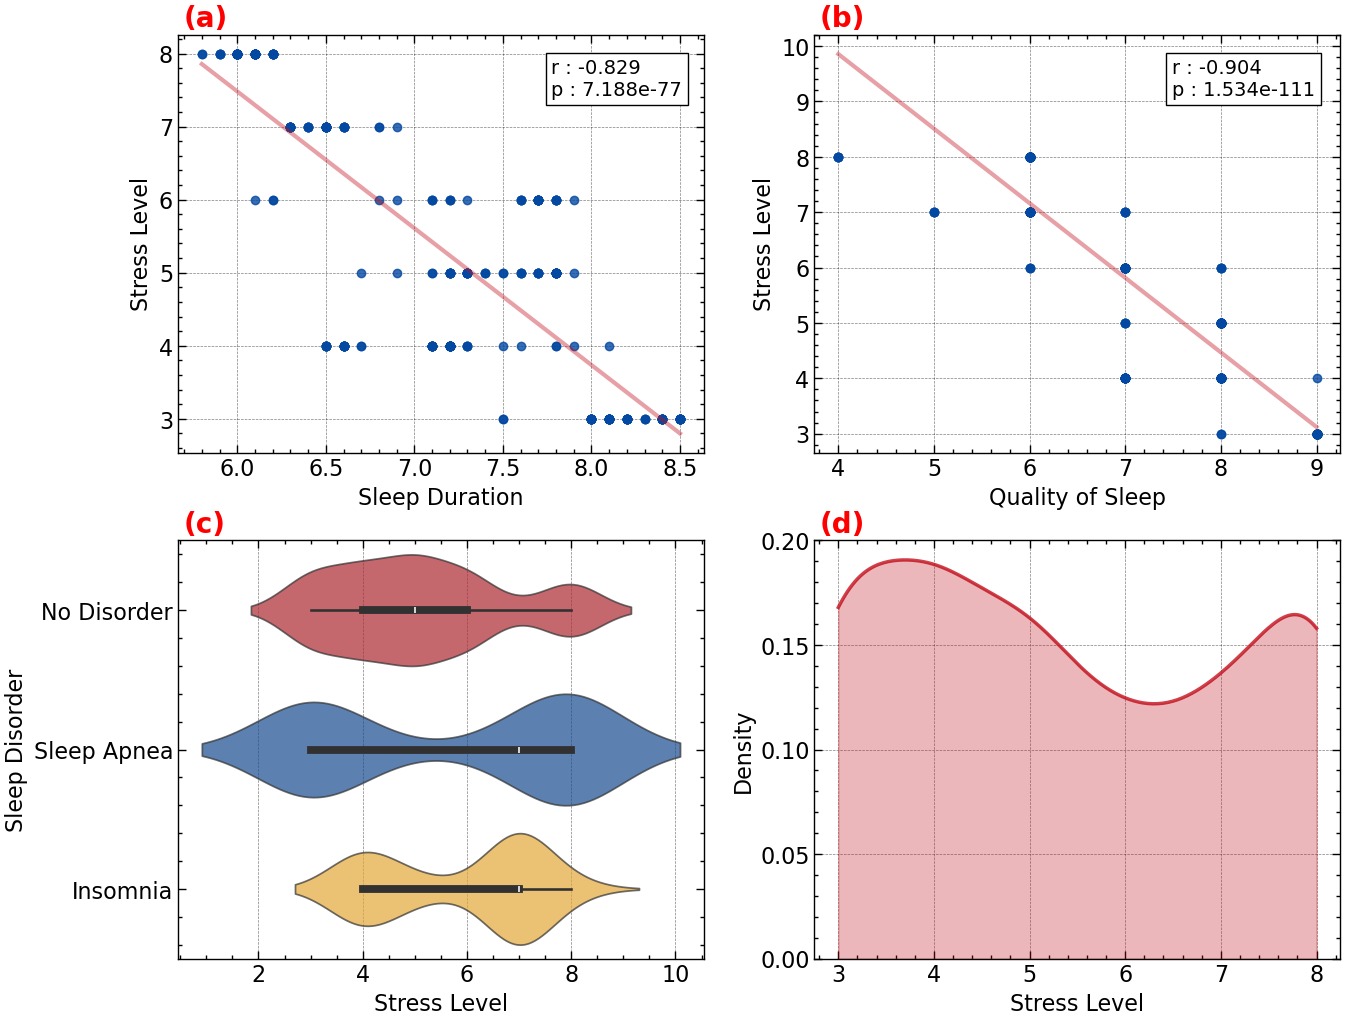

In [10]:
# ==========================================================
#               creating custom color pallet
# ==========================================================
seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608',
            '#0193b0', '#9c5300', '#949c01', '#7104b5']
#            0sangre,   1neptune,  2pumpkin,  3clover,   
#            4denim,    5cocoa,    6cumin,    7berry


# setting up the plot grid
fig = plt.figure(figsize=(15, 12), dpi=100)
gs = gridspec.GridSpec(2, 2, figure=fig)
gs.update(wspace=0.21, hspace=0.21)

# ==========================================================
# PLOT 1
ax = fig.add_subplot(gs[0])
lr = linregress(y=train_df['Sleep Duration'], x=train_df['Stress Level'])
sns.regplot(
    data=train_df,
    x='Sleep Duration',
    y='Stress Level',
    ci=False,
    line_kws=dict(color=seshadri[0], alpha=0.4),
    scatter_kws=dict(color=seshadri[1])
)

# print r and p value
ax.text(
    0.71, 0.855,
    f'r : {lr.rvalue:.3f} \np : {lr.pvalue:.3e}',
    fontsize=14,
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black')
)

# print figure label
ax.text(
    0.01, 1.02,
    '(a)',
    color='red',
    fontsize=20,
    fontweight='bold',
    transform=ax.transAxes
)

# ==========================================================
# PLOT 2
ax = fig.add_subplot(gs[1])
lr = linregress(y=train_df['Quality of Sleep'], x=train_df['Stress Level'])
sns.regplot(
    data=train_df,
    x='Quality of Sleep',
    y='Stress Level',
    ci=False,
    line_kws=dict(color=seshadri[0], alpha=0.4),
    scatter_kws=dict(color=seshadri[1])
)

# print r and p value
ax.text(
    0.68, 0.855,
    f'r : {lr.rvalue:.3f} \np : {lr.pvalue:.3e}',
    fontsize=14,
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black')
)

# print figure label
ax.text(
    0.01, 1.02,
    '(b)',
    color='red',
    fontsize=20,
    fontweight='bold',
    transform=ax.transAxes
)

# ==========================================================
# PLOT 3
ax = fig.add_subplot(gs[2])

sns.violinplot(
    data=train_df,
    y='Sleep Disorder',
    x='Stress Level',
    hue='Sleep Disorder',
    palette=seshadri,
    alpha=0.7,
    ax=ax
)

# print figure label
ax.text(
    0.01, 1.02,
    '(c)',
    color='red',
    fontsize=20,
    fontweight='bold',
    transform=ax.transAxes
)

# ==========================================================
# PLOT 4
ax = fig.add_subplot(gs[3])

kde = gaussian_kde(train_df['Stress Level'])
x_range = np.linspace(train_df['Stress Level'].min(),
                      train_df['Stress Level'].max(), 200)
y_kde = kde(x_range)

ax.plot(
    x_range,
    y_kde,
    color=seshadri[0],
    linewidth=2.5,
    alpha=0.8
)
ax.fill_between(x_range, y_kde, alpha=0.3, color=seshadri[0])
ax.set_xlabel('Stress Level')
ax.set_ylabel('Density')
ax.set_yticks(np.arange(0, 0.21, 0.05))
ax.set_ylim(0, 0.20)

# print figure label
ax.text(
    0.01, 1.02,
    '(d)',
    color='red',
    fontsize=20,
    fontweight='bold',
    transform=ax.transAxes
)

plt.show()

#### (a) Sleep Duration vs Stress
There's a strong negative correlation (r = -0.829, p = 7.188e-77), indicating that longer sleep duration is significantly associated with lower stress levels. This relationship is highly statistically significant.

#### (b) Quality of Sleep vs Stress
An even stronger negative correlation exists (r = -0.904, p = 1.534e-111), suggesting that better sleep quality has a more pronounced relationship with reduced stress than sleep duration alone. The extremely low p-value confirms this is not due to chance.

#### (c) Sleep Disorders and Stress Distribution
The violin plots reveal that individuals with no sleep disorder cluster at higher stress levels (centered around 5-6), while those with sleep apnea and insomnia show broader distributions with generally elevated stress. Insomnia cases appear to have slightly higher median stress levels than sleep apnea.

#### (d) Overall Stress Distribution
The bimodal density plot suggests two distinct subpopulations in the dataset - one centered around stress level 4 and another around stress level 7-8. This could indicate fundamentally different groups, possibly corresponding to those with and without sleep-related issues.

#### Overall Summary and Future Directions
The data strongly supports that both sleep quantity and quality are inversely related to stress, with sleep quality being the stronger predictor of stress levels. Given the clear linear trends observed in the data, implementing a Linear Regression model such as Ridge Regression would be an optimal approach to quantify how well these sleep-related features can explain variations in stress levels.

In [19]:
# Validate training data for anomalous correlations:
# - between the target (Sleep Disorder) and the features
# - between the features themselves
# These checks are run on the TRAIN split as part of EDA to make sure
# there are no suspiciously strong relationships that could indicate
# data leakage, data errors, or redundant features before we fit models.

df_train = train_df.copy()
df_train["Sleep Disorder"] = train_df["Sleep Disorder"]

sleep_train_ds = Dataset(df_train, label="Sleep Disorder", cat_features=[])

check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=sleep_train_ds)

check_feat_feat_corr = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(
    threshold=0.92,
    n_pairs=0
)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=sleep_train_ds)

if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature–label correlation exceeds the maximum acceptable threshold.")

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature–feature correlation exceeds the maximum acceptable threshold.")

### 3.5. Baseline Model

We separate the feature columns and the target column. 

In [11]:
X_train = train_df.drop(columns=["Stress Level"])
y_train = train_df["Stress Level"]
X_test = test_df.drop(columns=["Stress Level"])
y_test = test_df["Stress Level"]

We train a `DummyClassifier` as our baseline model. 

In [12]:
dummy = DummyClassifier()

dummy_scores = cross_validate(
    dummy,
    X_train,
    y_train,
    cv=5,
    return_train_score=True
)

dummy_df = pd.DataFrame(dummy_scores)
dummy_df

,fit_time,score_time,test_score,train_score
0,0.000793,0.000709,0.20000,0.200837
1,0.000757,0.000896,0.20000,0.200837
2,0.000658,0.000443,0.20000,0.200837
3,0.001087,0.000563,0.20000,0.200837
4,0.000691,0.000535,0.20339,0.200000


Our baseline model shows a validation accuracy of around 20%. We therefore aim for a test score higher than that. 

### 3.6. Column Transformation

We will perform standard scaling on `Sleep Duration` and one-hot encoding on `Sleep Disorder`. `Quality of Sleep` contains naturally ordered integers and therefore does not require transformation. 

We set up a `ColumnTransformer` to use in the pipeline.  

In [13]:
preprocesser = make_column_transformer(
    (StandardScaler(), ["Sleep Duration"]),
    (OneHotEncoder(), ["Sleep Disorder"]),
)

preprocesser

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Sleep Duration']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Sleep Disorder'])])

### 3.7. Training and Validation

In [14]:
ridge_pipe = make_pipeline(
    preprocesser,
    Ridge(alpha=1.0)
)

cv_results = cross_validate(
    ridge_pipe,
    X_train,
    y_train,
    cv=5,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True
)

cv_results_df = pd.DataFrame(cv_results).rename(columns={
    'test_neg_mean_squared_error': 'test_neg_MSE',
    'train_neg_mean_squared_error': 'train_neg_MSE'
})
cv_results_df

,fit_time,score_time,test_neg_MSE,train_neg_MSE,test_r2,train_r2
0,0.012623,0.005434,-0.966525,-0.939745,0.735982,0.702552
1,0.007594,0.003260,-1.115303,-0.901239,0.600846,0.733666
2,0.006127,0.003371,-0.941442,-0.952310,0.693674,0.712694
3,0.004949,0.003420,-0.769661,-0.989587,0.789710,0.688111
4,0.005032,0.002706,-1.068692,-0.914836,0.641952,0.726779


The linear regression model demonstrated strong generalization with a mean cross-validated score of 0.69, closely matching the mean training score of 0.71. This indicates that the three selected features robustly explain approximately 70% of the variance in the target variable with minimal overfitting.

### 3.9. Model Evaluation

The linear regression model explains approximately **52%** of the variance in stress levels ($R^2 \approx 0.52$). Given that stress levels range from 3 to 8 (range = 5), the RMSE between 1.2 to 1.3 represents approximately **25%** of this range, indicating moderate prediction accuracy.

In [15]:
ridge_pipe.fit(X_train, y_train)
y_pred = ridge_pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

MSE: 1.2503
R^2: 0.5171


Finally, we visualize the prediction results.

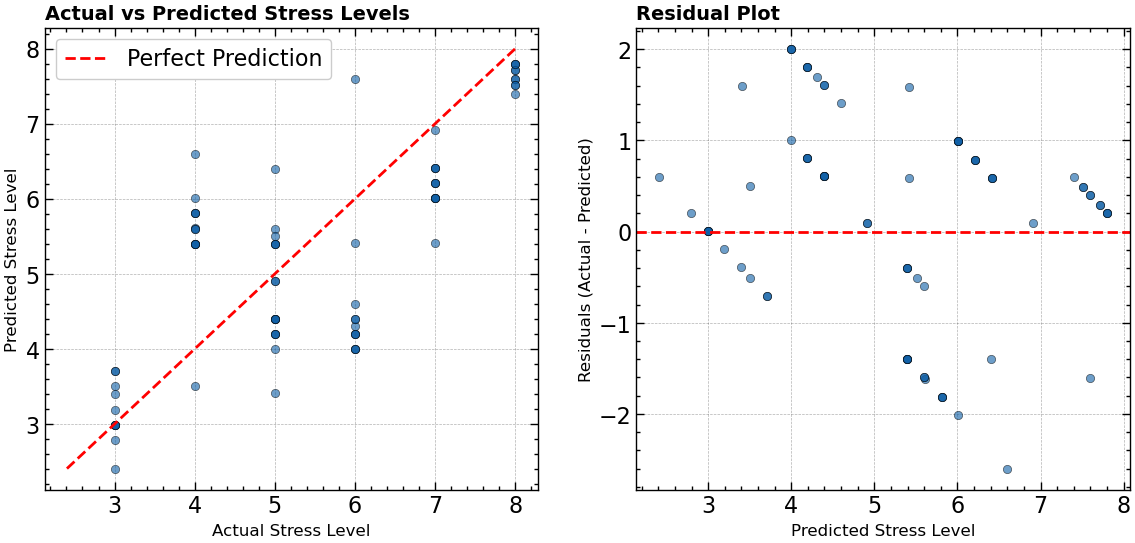

In [16]:
# Calculate residuals
residuals = y_test - y_pred

# Create figure with GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.2)

# ==========================================================
# PLOT 1: Actual vs Predicted
# prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

ax = fig.add_subplot(gs[0])
ax.scatter(
    y_test,
    y_pred,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5
)
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--',
    lw=2,
    label='Perfect Prediction'
)

ax.set_xlabel('Actual Stress Level', fontsize=12)
ax.set_ylabel('Predicted Stress Level', fontsize=12)
ax.set_title('Actual vs Predicted Stress Levels',
             fontsize=14, fontweight='bold', loc='left')
ax.legend()
ax.grid(True, alpha=0.3)

# ==========================================================
# PLOT 2: Residuals
ax = fig.add_subplot(gs[1])
ax.scatter(
    y_pred,
    residuals,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5
)
ax.axhline(y=0, color='r', linestyle='--', lw=2)

ax.set_xlabel('Predicted Stress Level', fontsize=12)
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax.set_title('Residual Plot', fontsize=14, fontweight='bold', loc='left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- **Actual vs Predicted:** The model shows moderate predictive performance with reasonable alignment along the diagonal line, though there's notable scatter indicating imperfect predictions, particularly for mid-range stress levels (4-6).

- **Residual Plot:** Residuals show a slight negative trend, suggesting the model tends to overpredict at lower stress levels and underpredict at higher stress levels, indicating potential non-linear relationships in the data.

## 4. Discussion

### Summary of Findings

The analysis revealed strong negative correlations between sleep duration, sleep quality, and stress levels, with sleep quality being the most significant predictor. The linear regression model explained approximately 52% of the variance in stress levels, indicating that these sleep-related features are meaningful but not exhaustive predictors of stress.

### Expected vs Actual Outcomes

The findings aligned with our expectations that better sleep patterns would correlate with lower stress levels. However, the model's moderate predictive accuracy suggests that while sleep is a crucial factor, other variables likely contribute significantly to stress. This highlights the complexity of stress as a multifaceted phenomenon influenced by various lifestyle, psychological, and environmental factors.

### Impact and Applications

Understanding the relationship between sleep and stress has important implications for public health. Interventions aimed at improving sleep quality and duration could be effective strategies for stress reduction. There is however a lingering question of which direction the causality goes—does poor sleep lead to higher stress, or does high stress lead to poor sleep? Future studies could explore this bidirectional relationship further.

### Future Work

Future research could try to establish the correct direction of causality between sleep and stress through longitudinal studies. Additionally, incorporating more comprehensive lifestyle and psychological variables could enhance the predictive power of models assessing stress levels. Exploring non-linear modeling techniques may also capture complex relationships not addressed by linear regression.

## 5. Refereneces

Centers for Disease Control and Prevention. (2024). *FastStats: Sleep in adults*. https://www.cdc.gov/sleep/data-research/facts-stats/adults-sleep-facts-and-stats.html

Husn, M. (2023). *Sleep health and lifestyle* [Data set]. GitHub. https://raw.githubusercontent.com/Muhanad-husn/Sleep-Health-and-Lifestyle/main/data.csv

Sleep Foundation. (2025). 100+ sleep statistics – Facts and data about sleep 2024. https://www.sleepfoundation.org/how-sleep-works/sleep-facts-statistics

Varishabatool. (n.d.). *Sleep health and lifestyle dataset* [Data set]. Kaggle. https://www.kaggle.com/datasets/varishabatool/disorder
